In [1]:
import numpy as np
import pandas as pd
import yaml
import os
import cv2
import shutil
import torch
from ultralytics import YOLO
from ultralytics.data.converter import convert_coco

METAINFO = {
    "classes": (
        "unlabelled",
        "asphalt/concrete",
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush/shrub",
        "fence",
        "other-structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (0  , 0  , 0  ),
        (230, 25 , 75 ),
        (60 , 180, 75 ),
        (255, 225, 25 ),
        (0  , 130, 200),
        (145, 30 , 180),
        (70 , 240, 240),
        (240, 50 , 230),
        (210, 245, 60 ),
        (250, 190, 190),
        (0  , 128, 128),
        (170, 110, 40 ),
        (255, 250, 200),
        (128, 0  , 0  ),
        (170, 255, 195),
        (128, 128, 0  ),
        (255, 215, 180),
        (0  , 0  , 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

# Parameters
NUM_CLASSES = 19
label_ids = {e: i for i, e in enumerate(METAINFO['classes'])}

In [2]:
PATH = 'dataset/'
def get_dfs():
    train_df = pd.read_csv(PATH + 'train.csv')
    val_df   = pd.read_csv(PATH + 'val.csv'  )
    test_df  = pd.read_csv(PATH + 'test.csv' )
    return (train_df, val_df, test_df)

train_df, val_df, test_df = get_dfs()

In [3]:
def create_yolo_labels(images_dest, labels_dest, df, n_class, create_path=False):
    if not os.path.exists(labels_dest):
        os.makedirs(labels_dest)
    if not os.path.exists(images_dest):
        os.makedirs(images_dest)

    for image_path, label_path in zip(df['im_path'], df['label_path']):
        image = os.path.basename(image_path)

        # Construct the full path to the destination label_txt
        if create_path:
            image_dest = os.path.join(images_dest, image)
            if not os.path.exists(image_dest):
                shutil.copy(image_path, image_dest)

        # create yolo labels
        label_dest = image.replace('.png', '.txt')
        convert_label_to_yolo(
            label_path, f'{labels_dest}\\{label_dest}', n_class
        )


def convert_label_to_yolo(label_path, out_path, n_class):
    label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    height, width = label_img.shape

    with open(out_path, 'w') as label_txt:
        for class_id in range(n_class):
            # Create a binary mask for the current class
            class_mask = cv2.inRange(label_img, class_id, class_id)

            # Find contours for the current class
            contours, _ = cv2.findContours(
                class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            for cnt in contours:
                if len(cnt) < 3:
                    continue
                normalized_points = [
                    (point[0][0] / width, point[0][1] / height) for point in cnt
                ]
                label_txt.write(
                    f'{class_id} ' + " ".join(
                        f'{x:.6f} {y:.6f}' for x, y in normalized_points
                    ) + "\n"
                )

In [ ]:
datasets = ['train' , 'val' ]
dfs      = [train_df, val_df]
for i, ds in enumerate(datasets):
    images_destination = PATH + f'{ds}/images'
    labels_destination = PATH + f'{ds}/labels'
    create_yolo_labels(
        images_destination, labels_destination, dfs[i], NUM_CLASSES,
        # create_path=True
    )

In [4]:
cuda_avail = torch.cuda.is_available()
if cuda_avail:
    torch.cuda.set_device(0)
    print("GPU available")
else:
    print("No GPU found")
print(f'Device count  : {torch.cuda.device_count()}')
print(f'Device in-use : {torch.cuda.current_device()}')

# model = YOLO('yolov8s-seg.yaml')
# model.model.nc    = NUM_CLASSES
# model.model.names = METAINFO['classes']

model = YOLO('yolov8/models/weights/best.pt')

GPU available
Device count  : 1
Device in-use : 0


In [6]:
# Train the model
model.train(
    data='dataset.yaml',
    epochs=30,
    batch=16,
    optimizer='AdamW',
    device=0,
    imgsz=640,
    patience=10,
    rect=False,
    verbose=False,
    pretrained=True,
)

Ultralytics YOLOv8.2.64  Python-3.12.2 torch-2.4.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=segment, mode=train, model=yolov8/models/weights/best.pt, data=dataset.yaml, epochs=30, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

train: Scanning C:\Users\thedu\OneDrive\Desktop\venv\Studies\9517\Assignment\COMP9517\dataset\train\labels.cache... 605


MemoryError: 

In [7]:
def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image

# from skimage.segmentation import slic, mark_boundaries
# from skimage import io, color, filters
# from skimage.segmentation import slic, mark_boundaries

# def calculate_edge_density(image, sigma=1.0):
#     """
#     Calculate edge density of the image.
#     """
#     edges = filters.sobel(color.rgb2gray(image))
#     edge_density = np.mean(edges)
#     return edge_density

# def adaptive_slic(image, base_segments=20, max_segments=200, sigma=1.0):
#     """
#     Run SLIC with an adaptive number of segments based on edge density.
#     """
#     edge_density = calculate_edge_density(image, sigma=sigma)
#     n_segments = int(base_segments + edge_density * (max_segments - base_segments))
#     segments = slic(image, n_segments=n_segments, compactness=10, sigma=sigma)
#     return segments


# def replace_unlabelled(image, prediction):
#     # superpixel ground truth
#     ground_truth = adaptive_slic(image)
#     # plt.imshow(ground_truth)
    
#     # Find the most frequent label in the ground truth
#     most_frequent_label = np.bincount(ground_truth.flatten()).argmax()
    
#     # Replace unlabelled pixels (0) in the prediction with the most frequent label
#     prediction[prediction == 0] = most_frequent_label
    
#     return prediction

from skimage import segmentation, filters, morphology, color, measure

def refine_segmentation(image, mask):
    """
    Refine the predicted mask using morphological operations and graph-based methods.
    
    :param image: Input image (H, W, 3).
    :param mask: Predicted segmentation mask (H, W).
    :return: Refined segmentation mask.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Smooth the mask using morphological operations
    refined_mask = morphology.opening(mask, morphology.disk(3))
    refined_mask = morphology.closing(refined_mask, morphology.disk(3))
    
    # Relabel connected components
    refined_mask = measure.label(refined_mask)
    
    return refined_mask


def reassign_unlabelled(prediction, unlabelled_class=0):
    prediction = prediction.astype('int64')
    # Find the indices of the unlabelled pixels
    unlabelled_indices = np.where(prediction == unlabelled_class)
    # Iterate through the unlabelled pixels
    for y, x in zip(*unlabelled_indices):
        # Get the 8-connected neighbors
        neighbors = prediction[max(0, y-1):y+2, max(0, x-1):x+2].flatten()
        # Remove the unlabelled class from the neighbors
        neighbors = neighbors[neighbors != unlabelled_class]
        # If there are no labelled neighbors, skip this pixel
        if len(neighbors) == 0:
            continue
        # Assign the most frequent class among the neighbors to the unlabelled pixel
        prediction[y, x] = np.bincount(neighbors).argmax()
    return prediction


def convert_instance_to_semantic(results, num_classes):
    # Assuming results is a list of instance segmentation results
    # num_classes is the total number of classes in your semantic segmentation task
    
    # Initialize an empty semantic segmentation map
    _, height, width = results[0].masks.data.cpu().numpy().shape  # Get the size of the input image
    semantic_map = np.zeros((height, width), dtype=np.uint8)
    
    # Iterate through each detected instance
    for result in results:
        masks = result.masks.data.cpu().numpy()
        boxes = result.boxes
        labels = boxes.cls.cpu().numpy()

        for label, mask, box in zip(labels, masks, boxes.xyxy):
            [ymin, xmin, ymax, xmax] = box
            ymin = int(max(0, ymin))
            xmin = int(max(0, xmin))
            ymax = int(min(height, ymax))
            xmax = int(min(width, xmax))
            semantic_map[mask != 0] = label
            # semantic_map[ymin:ymax, xmin:xmax] = label
        
        # # Assign class label to the pixels within the bounding box
        # semantic_map[mask != 0] = class_label
    segment_color = label_to_rgb(semantic_map, METAINFO['palette'])
    return segment_color

In [67]:
from scipy.ndimage import measurements

def find_adjacent_neighbors(label_image, hole_label=0):
    # Get the binary mask for the hole region
    hole_mask = (label_image == hole_label)

    # Label connected components of the hole region
    labeled_array, num_features = measurements.label(hole_mask)

    # Dictionary to store boundary lengths with neighboring regions
    neighbor_boundaries = {}

    # Iterate over each connected component (hole) found in the labeled image
    for label in range(1, num_features + 1):  # start from 1 because 0 is background
        # Get the coordinates of the current hole region
        hole_coords = np.where(labeled_array == label)
        hole_coords = list(zip(hole_coords[0], hole_coords[1]))

        # Iterate over each pixel in the current hole region
        for x, y in hole_coords:
            # Get neighbors around the current pixel
            neighbors = labeled_array[x-1:x+2, y-1:y+2]
            unique_neighbors = np.unique(neighbors)

            # Exclude the hole itself and background (label 0)
            unique_neighbors = [n for n in unique_neighbors if n != 0 and n != label]

            # Calculate boundary lengths with each neighboring region
            for neighbor_label in unique_neighbors:
                boundary_length = np.sum(neighbors == neighbor_label)
                if neighbor_label in neighbor_boundaries:
                    neighbor_boundaries[neighbor_label] += boundary_length
                else:
                    neighbor_boundaries[neighbor_label] = boundary_length

    # Find the neighbor with the maximum boundary contact for this specific hole region
    if neighbor_boundaries:
        max_neighbor_label = max(neighbor_boundaries, key=neighbor_boundaries.get)
        max_boundary_length = neighbor_boundaries[max_neighbor_label]
    else:
        # Handle case where there are no neighbors (shouldn't normally happen if there's at least one hole)
        max_neighbor_label = None
        max_boundary_length = 0

    return max_neighbor_label, max_boundary_length


0: 480x640 1 dirt, 6 tree-trunks, 1 tree-foliage, 6 skys, 2 grasss, 22.4ms
Speed: 1085.4ms preprocess, 22.4ms inference, 7.5ms postprocess per image at shape (1, 3, 480, 640)


(-0.5, 639.5, 479.5, -0.5)

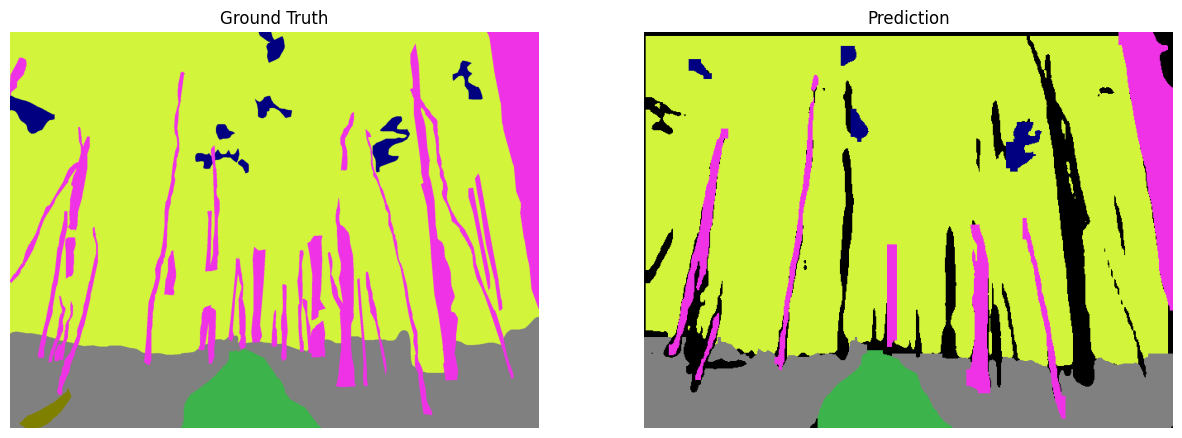

In [8]:
import matplotlib.pyplot as plt
from skimage import color

X_pred = list(test_df['im_path'])
results = model(X_pred[:1])
y_true = np.array(test_df['label_path']).astype(str)
_, height, width = results[0].masks.data.cpu().numpy().shape
semantic_map = np.zeros((height, width), dtype=np.uint8)

for result in results:
    masks  = result.masks.data.cpu().numpy()
    boxes  = result.boxes
    labels = boxes.cls.cpu().numpy()

    for label, mask in zip(labels, masks):
        semantic_map[mask != 0] = label
    semantic_map = label_to_rgb(semantic_map, METAINFO['palette'])
    # print(color.rgb2gray(result.orig_img))
    # semantic_map = refine_segmentation(color.rgb2gray(result.orig_img), semantic_map.astype('int64'))

# # Process results list
# for i, result in enumerate(results):
#     masks = result.masks.data.cpu().numpy()
#     boxes = result.boxes
#     class_indices = boxes.cls.cpu().numpy()
    
#     # segmented_image = np.zeros((masks.shape[0], masks.shape[1]), dtype=np.uint8)

#     # # Map masks to their corresponding class labels
#     # # for mask, class_idx in zip(masks, class_indices):
#     # #     class_name = result.names[int(class_idx)]
#     # #     print(f"Mask for class: {class_name}")
#     # #     print(mask.shape)
#     # for mask, class_idx in zip(masks, class_indices):
#     #     segmented_image[mask != 0] = class_idx

#     image = cv2.imread(X_pred[i], cv2.IMREAD_UNCHANGED)
#     combined_mask = np.zeros_like(masks[0])
    
#     for mask, class_idx in zip(masks, class_indices):
#         class_name = result.names[int(class_idx)]
#         mask[mask != 0] = class_idx
#         # print(mask[mask != 0][0])
#         # mask = np.where(mask != 0, class_idx, mask)
#         combined_mask = np.maximum(combined_mask, mask)
#     # print(np.max(combined_mask))

#     # combined_mask = replace_unlabelled(image, combined_mask)
#     # combined_mask = refine_segmentation(image, combined_mask.astype('int64'))
#     # combined_mask = reassign_unlabelled(combined_mask.astype('int64'))

#     # Optionally, apply a colormap for visualization
#     segment_color = label_to_rgb(combined_mask, METAINFO['palette'])
    
#     # boxes = result.boxes  # Boxes object for bounding box outputs
#     # masks = result.masks  # Masks object for segmentation masks outputs
#     # keypoints = result.keypoints  # Keypoints object for pose outputs
#     # probs = result.probs  # Probs object for classification outputs
#     # obb = result.obb  # Oriented boxes object for OBB outputs
#     # result.show()  # display to screen
#     # result.save(filename="result.jpg")

#     # arr = np.array(result.masks.data.cpu())
#     # print(np.count_nonzero(arr))
#     # print(result.masks.data.cpu())
#     # print(plt.imshow(result.masks.data.cpu()))

gt0 = cv2.imread(y_true[0], cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(label_to_rgb(gt0, METAINFO['palette']))
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(122)
plt.imshow(semantic_map)
plt.title("Prediction")
plt.axis('off')

In [6]:
# def extract_bounding_boxes(mask, class_id):
#     binary_mask = np.where(mask == class_id, 1, 0).astype(np.uint8)
#     contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     bounding_boxes = []
#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)
#         bounding_boxes.append((x, y, w, h))
#     return bounding_boxes

# def normalize_bbox(x, y, w, h, img_width, img_height):
#     x_center = (x + w / 2) / img_width
#     y_center = (y + h / 2) / img_height
#     width = w / img_width
#     height = h / img_height
#     return x_center, y_center, width, height

# def write_yolo_annotation(filename, class_id, bboxes):
#     with open(filename, 'w') as file:
#         for bbox in bboxes:
#             file.write(f'{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n')

# def convert_mask_to_yolo(mask_path, output_path):
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     img_height, img_width = mask.shape

#     unique_classes = np.unique(mask)
#     for class_id in unique_classes:
#         if class_id == 0:
#             continue  # Skip background
#         bounding_boxes = extract_bounding_boxes(mask, class_id)
#         normalized_boxes = [
#             normalize_bbox(x, y, w, h, img_width, img_height)
#             for x, y, w, h in bounding_boxes
#         ]
#         write_yolo_annotation(output_path, class_id, normalized_boxes)

# def create_yolo_labels(images_destination, labels_destination, df):
#     if not os.path.exists(labels_destination):
#         os.makedirs(labels_destination)

#     for image_path, label_path in zip(df['im_path'], df['label_path']):
#         label_path = label_path.replace('indexLabel', 'label')
#         image = os.path.basename(image_path)

#         # Construct the full path to the destination file
#         image_dest = os.path.join(images_destination, image)
#         shutil.copy(image_path, image_dest)

#         # create yolo labels
#         label = image.replace('.png', '.txt')
#         convert_mask_to_yolo(label_path, f'{labels_destination}\\{label}')

In [17]:
# Visualize results
def visualize(image, label, prediction, palette):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[1].imshow(label_to_rgb(label, palette))
    axes[1].set_title('Ground Truth')
    axes[2].imshow(label_to_rgb(prediction, palette))
    axes[2].set_title('Prediction')
    plt.show()

results = model.val(data='your_data.yaml')

# Accessing IoU (assuming results contain IoU)
iou_score = results.metrics['box'].iou

with torch.no_grad():
    for data in test_loader:
        images = data['image'].to(device)
        labels = data['label'].cpu().numpy()
        outputs = model(images).argmax(1).cpu().numpy()
        for i in range(len(images)):
            image = images[i].cpu().numpy().transpose(1, 2, 0)
            label = labels[i]
            prediction = outputs[i]
            visualize(image, label, prediction, METAINFO['palette'])
        break

Ultralytics YOLOv8.2.63  Python-3.12.2 torch-2.4.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Ultralytics YOLOv8.2.63  Python-3.12.2 torch-2.4.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Ultralytics YOLOv8.2.63  Python-3.12.2 torch-2.4.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=segment, mode=train, model=yolov8s-seg.yaml, data=coco8-seg.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train24, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1

100%|███████████████████████████████████████████████████████████████████████████████| 439k/439k [00:00<00:00, 18.8MB/s]
Unzipping C:\Users\thedu\OneDrive\Desktop\venv\Studies\9517\Assignment\COMP9517\coco8-seg.zip to C:\Users\thedu\OneDriv

Dataset download success  (1.8s), saved to C:\Users\thedu\OneDrive\Desktop\venv\Studies\9517\Assignment\COMP9517

Dataset download success  (1.8s), saved to C:\Users\thedu\OneDrive\Desktop\venv\Studies\9517\Assignment\COMP9517

Dataset download success  (1.8s), saved to C:\Users\thedu\OneDrive\Desktop\venv\Studies\9517\Assignment\COMP9517

Overriding model.yaml nc=19 with nc=80
Overriding model.yaml nc=19 with nc=80
Overriding model.yaml nc=19 with nc=80

                   from  n    params  module                                       arguments                     

                   from  n    params  module                                       arguments                     

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv            

 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2801504  ultralytics.nn.modules.head.Segment          [80, 32, 128, [128, 256, 512]]
 22        [15, 18, 21]  1   2801504  ultralytics.nn.modules.head.Segment          [80, 32, 128, [128, 256, 512]]
 22        [15, 18, 21]  1   2801504  ultralytics.nn.modules.head.Segment          [80, 32, 128, [128, 256, 512]]
YOLOv8s-seg summary: 261 layers, 11,821,056 parameters, 11,821,040 gradients, 42.9 GFLOPs
YOLOv8s-seg summary: 261 layers, 11,821,056 parameters, 11,821,040 gradients, 42.9 GFLOPs
YOLOv8s-seg summary: 261 layers, 11,821,056 parameters, 11,821,040 gradients, 42.9 GFLOPs



TensorBoard: Start with 'tensorboard --logdir runs\segment\train24', view at http://localhost:6006/
TensorBoard: Start with 'tensorboard --logdir runs\segmen

FileNotFoundError: [34m[1mtrain: [0mError loading data from C:\Users\thedu\OneDrive\Desktop\venv\Studies\9517\Assignment\datasets\coco8-seg\images\train
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

In [ ]:
# def convert_mask_to_yolo(img_path, label_path):
#     yolo_masks = []
#     masks = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

#     for i, mask in enumerate(masks):
#         # Convert the mask to a binary image
#         binary_mask = triangle_threshold(mask) # .astype(np.uint8)

#         # Find the contours of the mask
#         contours, hierarchy = cv2.findContours(
#             binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
#         )

#         # Get the largest contour based on area
#         largest_contour = max(contours, key=cv2.contourArea)

#         # Get the segmentation mask for object 
#         segmentation = largest_contour.flatten().tolist()
#         mask = segmentation

#         # convert mask to numpy array of shape (N,2)
#         mask = np.array(mask).reshape(-1,2)

#         # normalize the pixel coordinates
#         width, height = mask.shape
#         mask_norm = mask / np.array([width, height])

#         # compute the bounding box
#         xmin, ymin = mask_norm.min(axis=0)
#         xmax, ymax = mask_norm.max(axis=0)

#         # concatenate label and mask to obtain YOLO seg format
#         label = str(int(input_label[i].numpy())) + ' '
#         m_norm = ' '.join(map(str, mask_norm.reshape(-1)))
#         yolo_line = label + m_norm +'\n'
#         yolo_masks.append(yolo_line)

#     # os.chdir('Segmented_labels')
#     with open(label_path, 'a') as f:
#         for val in yolo_masks:
#             f.write(val)
#         f.write('\n')